In [1]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
#from netCDF4 import Dataset
import matplotlib
from datetime import datetime, timedelta, time
import glob
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering
import global_settings as gs
import pandas as pd
#import ARLreader as Ar
import preprocessing as prep
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline


C:\Users\addalin\Dropbox\Lidar\code\miscLidar.py:40: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [2]:
'''set day'''
day_date = datetime(2017,9,1)

'''set station'''
haifa_station = gs.station()

'''Set paths'''
#lidar_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\data\level1a\PollyXT_TROPOS'
#gdas_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\GDAS\haifa'
lidar_parent_folder = haifa_station.lidar_src_folder
haifa_station.gdas1_folder = os.path.join('.','data examples','gdas')
haifa_station.gdastxt_folder  = os.path.join('.','data examples','gdas_txt')


#gdas1_folder,gdas1_paths = prep.get_gdas_paths(haifa_station, day_date,'gdas1')
#print('gdas1',gdas1_paths)

#convert cur day (gdas files from TROPOS to txt)
gdastxt = prep.convert_daily_gdas ( haifa_station, day_date  )
print('gdas_txt',gdastxt)

#convert next day (gdas files from TROPOS to txt)
next_day = day_date + timedelta ( days = 1 )
gdastxt_nextday = prep.convert_daily_gdas ( haifa_station, next_day )
# gdastxt.extend(prep.convert_daily_gdas ( next_day , haifa_station ))
print('gdas_txt next day',gdastxt_nextday)


gdas_txt ['.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_00_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_03_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_06_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_09_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_12_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_15_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_18_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_21_32.8_35.0.txt']
gdas_txt next day ['.\\data examples\\gdas_txt\\2017\\09\\haifa_20170902_00_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170902_03_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170902_06_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170902_09_32.8_35.0.txt', '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170902_12_32.8_35.0.txt', '.\\data examples\\gda

In [3]:
'''set parameters'''
lambda_nm = gs.LAMBDA_nm().G
df_sigma , df_beta = prep.get_daily_molecular_profiles( haifa_station , day_date , lambda_nm , 'Km' )

In [4]:
df_hours =pd.date_range(start = day_date, end = next_day,freq = timedelta(hours = 3))
timestamps = df_hours.tolist()
paths = [prep.get_gdas_fname(haifa_station,time) for time in df_hours]

paths

['.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_00_32.8_35.0.txt',
 '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_03_32.8_35.0.txt',
 '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_06_32.8_35.0.txt',
 '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_09_32.8_35.0.txt',
 '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_12_32.8_35.0.txt',
 '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_15_32.8_35.0.txt',
 '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_18_32.8_35.0.txt',
 '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170901_21_32.8_35.0.txt',
 '.\\data examples\\gdas_txt\\2017\\09\\haifa_20170902_00_32.8_35.0.txt']

In [5]:
[os.path.exists(path) for path in paths]

[True, True, True, True, True, True, True, True, True]

<Figure size 432x288 with 0 Axes>

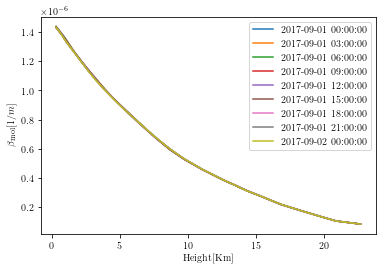

In [6]:
plt.figure()
ax = df_beta.plot()
ax.set_ylabel(r'$\beta_{\rm mol}[1/m]$')
plt.show()

In [17]:
def generate_daily_att_bsc_mol(station, day_date, lambda_nm, time_res='30S', height_units ='Km'):
	"""	 """

	'''Load daily gdas profiles and convert to backscatter (beta) and extinction (sigma) profiles'''

	df_sigma , df_beta = prep.get_daily_molecular_profiles ( station , day_date , lambda_nm , height_units )

	''' Interpolate profiles through 24 hrs'''
	interp_sigma_df=(df_sigma.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_beta_df=(df_beta.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_sigma_df.columns.freq = None
	interp_beta_df.columns.freq = None

	'''Calculate the molecular attenuated backscatter as :  beta_mol * exp(-2*tau_mol)'''
	e_tau_df = interp_sigma_df.apply(prep.cal_e_tau_df,0,args=(haifa_station.altitude,),result_type='expand')
	print ('e_tau ',e_tau_df)
	att_bsc_mol_df = interp_beta_df.multiply(e_tau_df)
	att_bsc_mol_df.rename_axis ('Height[{}]'.format ( height_units ) )

	import xarray as xr
	mol_xr= xr.DataArray(data=[interp_beta_df,interp_sigma_df,att_bsc_mol_df],
                     coords=[['beta','sigma','att_bsc_mol'],interp_beta_df.index,interp_beta_df.columns],
                     dims = ['profiles','Height','Time'],
                     name='molecular')#,interp_beta_df.index,interp_beta_df.columns )

	return att_bsc_mol_df,mol_xr

In [18]:
print('df_mol')
lambda_nm = gs.LAMBDA_nm().G
haifa_station = gs.station()
mol_df,mol_xr = generate_daily_att_bsc_mol( haifa_station, day_date, lambda_nm,time_res='30S')
mol_xr

df_mol
Float64Index([            0.30775, 0.31522146053684563, 0.32269292107369124,
              0.33016438161053685,  0.3376358421473825,  0.3451073026842281,
              0.35257876322107373, 0.36005022375791934, 0.36752168429476495,
              0.37499314483161056,
              ...
                22.64741700516839,  22.654888465705234,  22.662359926242083,
               22.669831386778927,  22.677302847315772,  22.684774307852617,
               22.692245768389462,   22.69971722892631,  22.707188689463155,
                      22.71466015],
             dtype='float64', name='Height[Km]', length=3000)
Float64Index([            0.30775, 0.31522146053684563, 0.32269292107369124,
              0.33016438161053685,  0.3376358421473825,  0.3451073026842281,
              0.35257876322107373, 0.36005022375791934, 0.36752168429476495,
              0.37499314483161056,
              ...
                22.64741700516839,  22.654888465705234,  22.662359926242083,
               22.6

<xarray.DataArray 'molecular' (profiles: 3, Height: 3000, Time: 2880)>
array([[[1.43876581e-06, 1.43876355e-06, 1.43876129e-06, ...,
         1.43152413e-06, 1.43152573e-06, 1.43152734e-06],
        [1.43790604e-06, 1.43790375e-06, 1.43790147e-06, ...,
         1.43063545e-06, 1.43063697e-06, 1.43063848e-06],
        [1.43704599e-06, 1.43704369e-06, 1.43704139e-06, ...,
         1.42974639e-06, 1.42974782e-06, 1.42974924e-06],
        ...,
        [8.38648559e-08, 8.38651337e-08, 8.38654115e-08, ...,
         8.36953909e-08, 8.36948784e-08, 8.36943660e-08],
        [8.37789800e-08, 8.37792581e-08, 8.37795362e-08, ...,
         8.36089534e-08, 8.36084399e-08, 8.36079264e-08],
        [8.36931164e-08, 8.36933948e-08, 8.36936732e-08, ...,
         8.35225293e-08, 8.35220147e-08, 8.35215002e-08]],

       [[1.22213220e-05, 1.22213023e-05, 1.22212825e-05, ...,
         1.21590354e-05, 1.21590491e-05, 1.21590627e-05],
        [1.22140184e-05, 1.22139984e-05, 1.22139784e-05, ...,
         1.21514925e-05, 1.21515054e-05, 1.21515183e-05],
        [1.22067123e-05, 1.22066922e-05, 1.22066721e-05, ...,
         1.21439463e-05, 1.21439585e-05, 1.21439706e-05],
...
        [7.12568384e-07, 7.12570744e-07, 7.12573104e-07, ...,
         7.11128503e-07, 7.11124149e-07, 7.11119794e-07],
        [7.11838728e-07, 7.11841091e-07, 7.11843454e-07, ...,
         7.10394076e-07, 7.10389713e-07, 7.10385350e-07],
        [7.11109177e-07, 7.11111543e-07, 7.11113908e-07, ...,
         7.09659762e-07, 7.09655390e-07, 7.09651018e-07]],

       [[1.44683080e-06, 1.44682852e-06, 1.44682623e-06, ...,
         1.43950752e-06, 1.43950914e-06, 1.43951077e-06],
        [1.44596595e-06, 1.44596364e-06, 1.44596133e-06, ...,
         1.43861363e-06, 1.43861516e-06, 1.43861669e-06],
        [1.44510082e-06, 1.44509849e-06, 1.44509616e-06, ...,
         1.43771935e-06, 1.43772079e-06, 1.43772223e-06],
        ...,
        [8.43175759e-08, 8.43178543e-08, 8.43181328e-08, ...,
         8.41448190e-08, 8.41443043e-08, 8.41437896e-08],
        [8.42312354e-08, 8.42315143e-08, 8.42317931e-08, ...,
         8.40579165e-08, 8.40574008e-08, 8.40568850e-08],
        [8.41449074e-08, 8.41451865e-08, 8.41454657e-08, ...,
         8.39710273e-08, 8.39705106e-08, 8.39699938e-08]]])
Coordinates:
  * profiles  (profiles) <U11 'beta' 'sigma' 'att_bsc_mol'
  * Height    (Height) float64 0.3078 0.3152 0.3227 0.3302 ... 22.7 22.71 22.71
  * Time      (Time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30

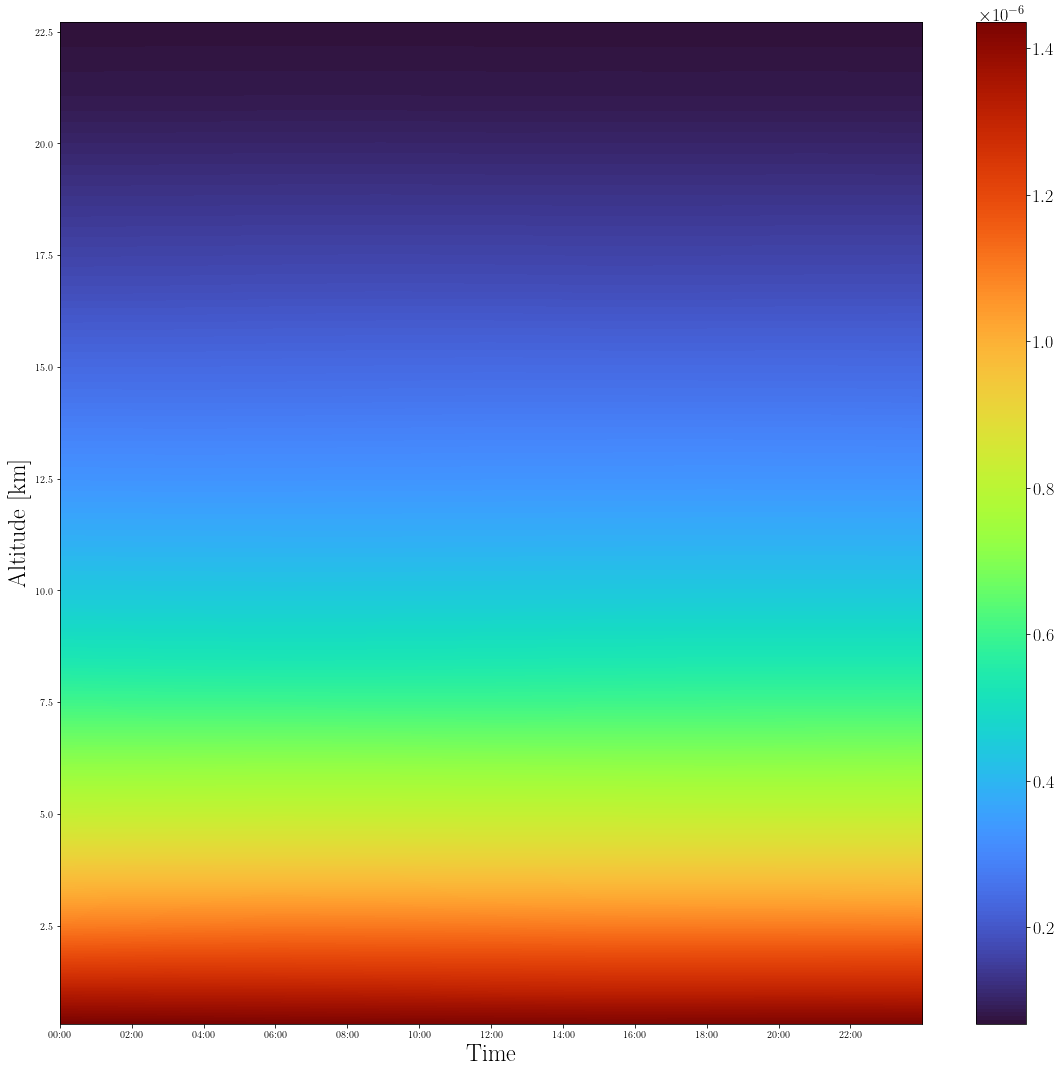

In [9]:
cur_df= mol_df
x_lims = mdates.date2num([cur_df.columns[0],cur_df.columns[-1]])
y_lims = [cur_df.index[0]*1E-3, cur_df.index[-1]*1E-3]
extent = [x_lims[0],x_lims[1],y_lims[0],y_lims[1] ]
fig, ax = plt.subplots(figsize=(16,15))
im = ax.imshow(cur_df, origin='lower',aspect='auto',cmap = 'turbo',
               extent=extent)#[0,2779,interp_sigma_df.index[0], interp_sigma_df.index[-1]])

ax.set_ylabel('Altitude [km]',fontsize = 24)
ax.set_xlabel('Time',fontsize = 24)
plt.rc('xtick',labelsize = 18)
plt.rc('ytick',labelsize = 18)
fig.colorbar(im,ax= ax)
ax.xaxis_date()
ax.get_xaxis().set_major_locator(mdates.MinuteLocator(interval=120))
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
fig.tight_layout()
plt.show()

In [10]:
# TODO: generate daily molecular mol_df - for several days
# TODO: validate units of height, speed of light, sigma and beta !!! (km or m)
# TODO: define attributes of mol_xr
# TODO: create xarray to a daily molecular profile for three channels (UV,G,IR)
# TODO: convert from xarray to pytorch
# TODO: save xarray as netcd file
# TODO: create table of profiles (for the data loader)

# TODO: Create samples of 30 min acording to 'profiles' times
# for the followings :
# X = {lidar measurement (range corrected) molecular (range corrected)}
# Y = {lidar const, reference height [min,max]}

## AERONET : https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=Technion_Haifa_IL&nachal=0&year=2017&month=5&day=19&aero_water=0&level=3&if_day=0&if_err=0&place_code=10&DATA_TYPE=-999&year_or_month=3
## it is possible to merge with Terra MODIS or Aqua MODIS -
# / TODO: locate the function that does donwload of sunphotometer data to cameranetwork (maybe Shubi knows this)
# / TODO: ask about the relevant product from MODIS to our porpose.



In [11]:
bsc_paths, profile_paths = prep.load_att_bsc(lidar_parent_folder, day_date)
bsc_paths
profile_paths

['H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_00_00_01_0000_0059_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_00_00_01_0134_0308_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_00_00_01_0309_0442_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_06_00_01_0905_0957_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_18_00_01_1800_1859_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_18_00_01_1900_2010_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\2017\\09\\01\\2017_09_01_Fri_TROPOS_18_00_01_2013_2113_profiles.nc',
 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1